In [7]:
%matplotlib inline

In [8]:
import os, sys

In [9]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from datetime import timedelta

In [10]:
import functools

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller


class SadfTest:
    """ Suppremum-Augmented Dickey Fuller Test
    TODO: Implment quantile and conditional SADF test features described in de Prado.
    Ref: de Prado Section 17.3.2
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
    """
    def __init__(self, ticks_required, minimum_sample_length_perc=0.5):
        self.ticks_required = ticks_required
        # out name should uniquely identify the feature with all its args
        self.output_column_names = [
            '{0}_sadf_test'.format(self.ticks_required)]

        self.minimum_sample_length = int(ticks_required
                                         * minimum_sample_length_perc)
        assert self.minimum_sample_length <= ticks_required
        # TODO: Investigate how the number of lags effects the result
        self.lag_order = 1
        self.minimum_sample_length = int(ticks_required
                                         * minimum_sample_length_perc)
        self.minimum_sample_length = max(self.minimum_sample_length,
                                         self.lag_order + 1)



        def compute_sdaf_stat(x):
            def adf(s_idx):
                # TODO: Investigate the effect of adding time trend to the specification.
                return adfuller(x[s_idx:], maxlag=self.lag_order,
                                autolag=None)[0]
            start_points = range(0, len(x) - self.minimum_sample_length)
            # TODO: This can perhaps be sped up using Pandas expanding windows and apply function.
            return functools.reduce(max, map(adf, start_points))

        buffer = pd.Series(data=np.empty(self.ticks_required))

        def compute_sdaf_stat_vec(x):
            """
            This vectorized version is not faster.
            """
            def adf(y):
                return adfuller(y[::-1],  maxlag=self.lag_order,
                                autolag=None)[0]

            buffer.iloc[:] = x[::-1]
            expanding = buffer.expanding(min_periods=self.minimum_sample_length)
            return expanding.apply(adf).max()

        self.compute_sdaf_stat = compute_sdaf_stat
        # self.compute_sdaf_stat = compute_sdaf_stat_vec


    def generate_bulk(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        rolling = log_prices.rolling(self.ticks_required,
                                     min_periods=self.ticks_required)

        data = (
            rolling.apply(self.compute_sdaf_stat, raw=True)
            .values).astype(np.float)

        return pd.DataFrame(index=reg_ticks.index,
                            data=data,
                            columns=self.output_column_names)


In [11]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='USDT_BTC', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [12]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=900)
#no option to pass in 3600 sec candles
#df = df[df.index % 4 == 0]
#df['ds'] = pd.to_datetime(df['date'], unit='s')
#df['y'] = df['volume']
#df['logVolume'] = df['volume'].apply(np.log)

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [13]:
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,1143.999999,1483601400,1145.000000,1135.000000,1137.020000,9.170638,10475.203351,1142.254643
1,1146.628895,1483602300,1146.628895,1141.242295,1143.999998,21.620561,24698.210829,1142.348302
2,1146.628879,1483603200,1148.561412,1142.000000,1146.628895,21.086122,24164.714141,1146.000865
3,1124.500000,1483604100,1148.799997,1120.000000,1142.000000,98.798854,111593.901661,1129.506029
4,1136.000000,1483605000,1136.000000,1124.018000,1124.500000,23.515077,26504.327610,1127.120601


In [14]:
adfuller(df.close, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-1.6082829701493424,
 0.47943148889556203,
 59,
 61741,
 {'1%': -3.430455919436007,
  '5%': -2.8615868144116114,
  '10%': -2.5667949177288434},
 660222.3935897641)

In [37]:
sadf = SadfTest(128)
sadf1 = SadfTest(256)
sadf512 = SadfTest(512)

In [32]:
sadf.compute_sdaf_stat(df.close)

-0.35256850015334334

In [34]:
bulk = sadf.generate_bulk(df)
bulk.dropna();

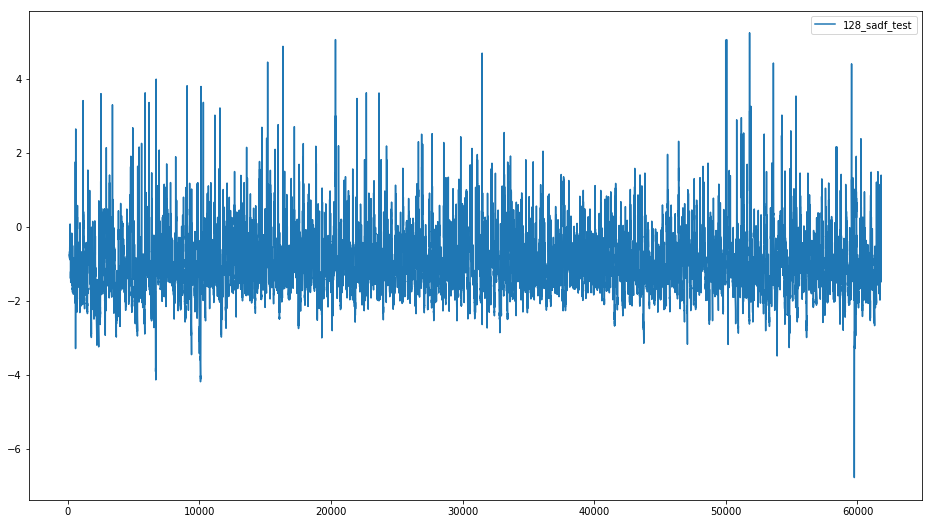

In [29]:
bulk.plot(figsize=(16,9))

In [35]:
bulk1 = sadf1.generate_bulk(df)
bulk1.dropna();

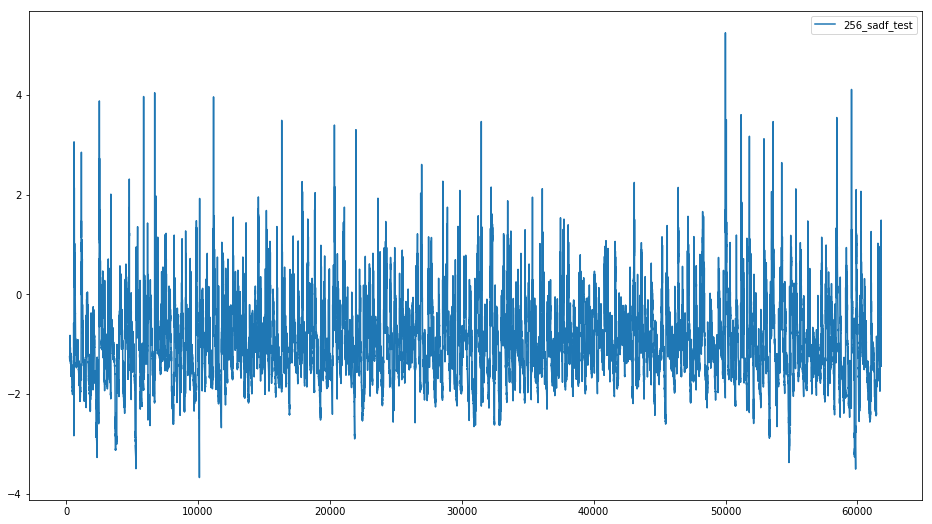

In [36]:
bulk1.plot(figsize=(16,9))

In [ ]:
bulk512 = sadf.generate_bulk(df)
bulk512.dropna();

In [19]:
sadf_features = StructuralBreakFeatures([
    ('sadf_test', 2),     # 128 day lookback SADF
    ('sadf_test', 4),     # 128 day lookback SADF
    ('sadf_test', 8),     # 128 day lookback SADF
    ('sadf_test', 16),     # 128 day lookback SADF
    ('sadf_test', 32),     # 128 day lookback SADF
    ('sadf_test', 64),     # 128 day lookback SADF
    ('sadf_test', 128),     # 128 day lookback SADF
    ('sadf_test', 256),     # 256 day lookback SADF
    ('sadf_test', 512),     # 512 day lookback SADF
    ('sadf_test', 1024),     # 512 day lookback SADF
])

NameError: name 'StructuralBreakFeatures' is not defined

In [ ]:
sadf_enriched = sadf_features.get_feature_data(df)
print(sadf_enriched.tail(2))

In [ ]:
#I do not have the code for the Feature Generator so there is an error and the code is unable to run.

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['2_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['4_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['8_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['16_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['32_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['64_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['128_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['256_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['512_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['1024_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)